<a href="https://colab.research.google.com/github/ZKisielewska/learning-git-task/blob/master/M_16_4_Unspupervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will deal with a dataset from Samsung phones regarding physical activity. The data is collected in the **Samsung_HAR**.zip [file](https://uploads.kodilla.com/bootcamp/pro-machine-learning/3/Samsung_HAR.zip).

We will try to group people based solely on the features available. Next, we solve the problem of determining the type of physical activity as a classification problem.

In [165]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

import warnings
warnings.filterwarnings('ignore')

In [166]:
# load the dataset
X_train = np.loadtxt('/content/drive/MyDrive/samsung_HAR/samsung_train.txt')
y_train = np.loadtxt('/content/drive/MyDrive/samsung_HAR/samsung_train_labels.txt').astype(int)

X_test = np.loadtxt('/content/drive/MyDrive/samsung_HAR/samsung_test.txt')
y_test = np.loadtxt('/content/drive/MyDrive/samsung_HAR/samsung_test_labels.txt').astype(int)

In [167]:
# convert the raw data to integer values
y_train

array([5, 5, 5, ..., 2, 2, 2])

In [168]:
# convert the raw data to integer values
y_test

array([5, 5, 5, ..., 2, 2, 2])

In [169]:
# checking dimensions
X_train.shape

(7352, 561)

In [170]:
assert X_train.shape == (7352, 561) and y_train.shape == (7352,)
assert X_test.shape == (2947, 561) and y_test.shape == (2947,)

For clustering, we do not need a target vector, so we'll work with the combination of training and test samples. Merge X_train with X_test, and y_train with y_test.

In [171]:
X = np.concatenate((X_train,X_test),axis=0)
y = np.concatenate((y_train,y_test),axis=0)

In [172]:
y.shape

(10299,)

In [173]:
# define the number of unique values of the labels of the target class.
unique_classes=np.unique(y)

In [174]:
n_classes = np.unique(y).size

**These labels correspond to:**

1 – walking

2 – walking upstairs

3 – walking downstairs

4 – sitting

5 – standing

6 – laying

For scale the sample we will use **StandardScaler** with default parameters.

In [175]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

We **reduce the number of dimensions** using **PCA**, leaving as many elements as needed to explain at least 90% of the variance in the original (scaled) data. We use a scaled dataset and fix random_state (RANDOM_STATE constant).

In [176]:
# minimum number of principal components thet require to cover the 90% of the variance of the original (scaled) data
pca = PCA(n_components=0.9, random_state=RANDOM_STATE).fit(X_scaled)
X_pca = pca.transform(X_scaled)

X_pca.shape

(10299, 65)

In [177]:
#percentage of the variance covered by the first principal component
round(float(pca.explained_variance_ratio_[0] * 100))

51

In [178]:
df = pd.DataFrame(np.column_stack((X_scaled,y)))
df.rename(columns = {561: 'test'}, inplace = True)
df["pca-one"] = X_pca[:,0]
df["pca-two"] = X_pca[:,1]
df.head()

,0,1,2,3,4,5,6,7,8,9,...,554,555,556,557,558,559,560,test,pca-one,pca-two
0,0.210534,-0.068703,-0.452195,-0.883335,-0.945431,-0.744387,-0.874687,-0.944877,-0.773250,-0.868773,...,-0.357898,0.062039,-0.782988,-0.019034,-0.674432,0.382008,-0.016151,5.0,-16.380980,1.995083
1,0.060208,0.035902,-0.275222,-0.890098,-0.929817,-0.860322,-0.883627,-0.927796,-0.858859,-0.884263,...,0.135993,-0.022538,-1.217721,1.470315,-0.681360,0.383148,-0.000121,5.0,-15.582173,1.182594
2,0.078460,-0.046427,-0.085548,-0.883565,-0.913598,-0.906457,-0.878093,-0.904569,-0.908437,-0.876139,...,-0.375145,0.391762,0.134732,1.686961,-0.689471,0.384289,0.019214,5.0,-15.423989,2.243166
3,0.071375,-0.227794,-0.270741,-0.885188,-0.946015,-0.935521,-0.879495,-0.943980,-0.938095,-0.876139,...,-0.132194,-0.034739,1.010013,-0.982261,-0.688915,0.388536,0.024624,5.0,-15.647807,3.762882
4,0.033738,0.031617,-0.121380,-0.889855,-0.940846,-0.935041,-0.882451,-0.937622,-0.940948,-0.883152,...,0.343504,0.268015,1.096950,-1.251689,-0.687381,0.399066,0.038649,5.0,-15.842320,4.438897


<Axes: xlabel='pca-one', ylabel='pca-two'>

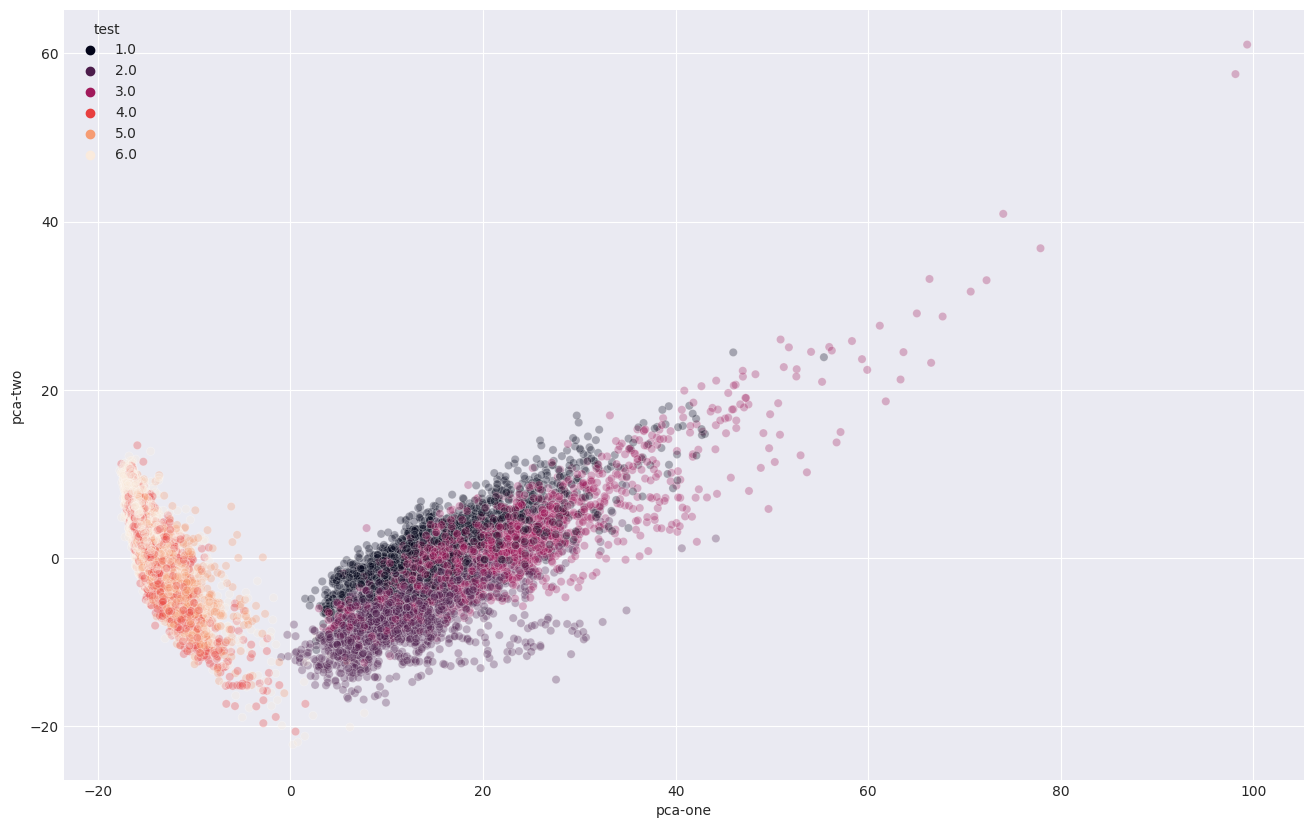

In [179]:
# visualize data in projection on the first two principal components
plt.figure(figsize=(16,10))

sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="test",
    data=df,
    legend="full",
    palette="rocket",
    alpha=0.3
)

We can see two main clusters:

- 1 - sitting, standing, laying
- 2 - walking, walking upstairs, walking downstairs

First contains no movement activity and second one with movement activity.

## **KMeans**

As a result of the algorithm, we receive the assignment of individual samples to individual groups/clusters. We will visualize how the algorithm made the assignment.

In this case, we are looking for exactly **6 clusters**, but in the general case we will not know how many clusters we should be looking for.

Options:

- **n_clusters** = n_classes (number of unique target class labels)
- **n_start** = 100
- **random_state** = RANDOM_STATE (for reproducible result)
Other parameters should have default values.

In [180]:
kmeans = KMeans(n_clusters=6, random_state=RANDOM_STATE, n_init=100).fit(X_scaled)

In [181]:
df['kmeans_cluster'] = np.array(kmeans.labels_)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,555,556,557,558,559,560,test,pca-one,pca-two,kmeans_cluster
0,0.210534,-0.068703,-0.452195,-0.883335,-0.945431,-0.744387,-0.874687,-0.944877,-0.773250,-0.868773,...,0.062039,-0.782988,-0.019034,-0.674432,0.382008,-0.016151,5.0,-16.380980,1.995083,4
1,0.060208,0.035902,-0.275222,-0.890098,-0.929817,-0.860322,-0.883627,-0.927796,-0.858859,-0.884263,...,-0.022538,-1.217721,1.470315,-0.681360,0.383148,-0.000121,5.0,-15.582173,1.182594,4
2,0.078460,-0.046427,-0.085548,-0.883565,-0.913598,-0.906457,-0.878093,-0.904569,-0.908437,-0.876139,...,0.391762,0.134732,1.686961,-0.689471,0.384289,0.019214,5.0,-15.423989,2.243166,4
3,0.071375,-0.227794,-0.270741,-0.885188,-0.946015,-0.935521,-0.879495,-0.943980,-0.938095,-0.876139,...,-0.034739,1.010013,-0.982261,-0.688915,0.388536,0.024624,5.0,-15.647807,3.762882,4
4,0.033738,0.031617,-0.121380,-0.889855,-0.940846,-0.935041,-0.882451,-0.937622,-0.940948,-0.883152,...,0.268015,1.096950,-1.251689,-0.687381,0.399066,0.038649,5.0,-15.842320,4.438897,4


We visualize data in projection on the **first two principal components**. Colors of the dots according to the clusters obtained.

<Axes: xlabel='pca-one', ylabel='pca-two'>

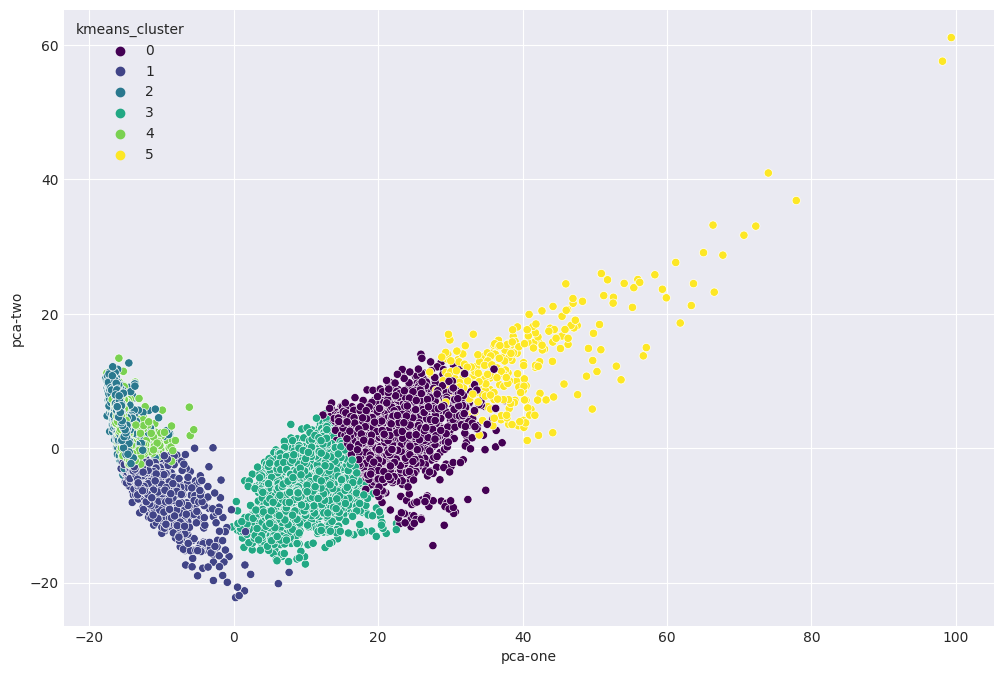

In [182]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x = 'pca-one', y = 'pca-two',
    hue='kmeans_cluster',
    data=df, palette='viridis',
    legend='full'
)

In [183]:
kmeans_clusters=df["kmeans_cluster"]
tab = pd.crosstab(y, kmeans_clusters, margins=True)
tab.index = ['walking',
             'going upstairs',
             'going downstairs',
             'sitting',
             'standing',
             'laying',
             'all']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['all']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,all
walking,742,0,0,903,0,77,1722
going upstairs,295,2,0,1242,0,5,1544
going downstairs,889,0,0,321,0,196,1406
sitting,0,451,91,1,1234,0,1777
standing,0,566,0,0,1340,0,1906
laying,0,330,1556,5,53,0,1944
all,1926,1349,1647,2472,2627,278,10299


We can see that for each class (**each activity**) there are **several clusters**. We can clculate the maximum percentage of objects in a class that are assigned to a single cluster. This will show us how the class is separated from others when clustering.

**Example:** if for class "**walking downstairs**" (with 1406 instances belonging to it), the distribution of clusters is:

- cluster 1 - 889
- cluster 4 - 321
- cluster 6 - 196,
then such a share will be 889/1406  ≈ **0.63**.

In [184]:
pd.Series(
    tab.iloc[:-1, :-1].max(axis=1).values / tab.iloc[:-1, -1].values,
    index=tab.index[:-1],
)

walking             0.524390
going upstairs      0.804404
going downstairs    0.632290
sitting             0.694429
standing            0.703043
laying              0.800412
dtype: float64

It can be seen that kMeans does not distinguish activities very well. We can use the **elbow method** to select the optimal number of clusters.

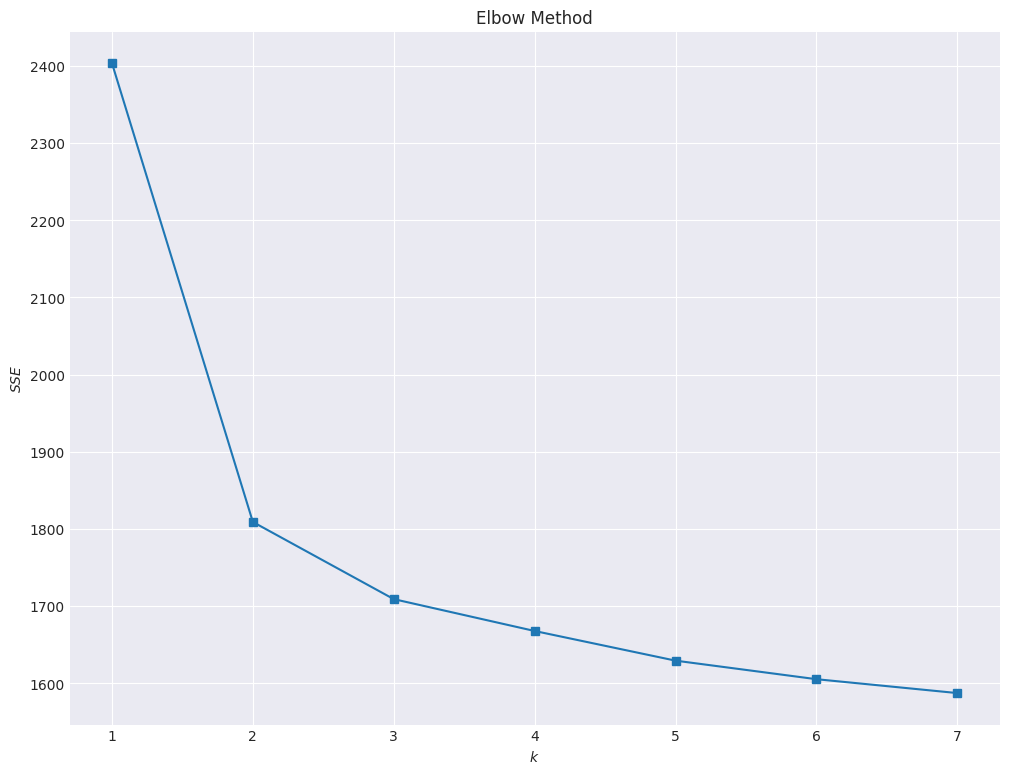

In [185]:
inertia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X_scaled)
    inertia.append(np.sqrt(kmeans.inertia_))



plt.plot(range(1, 8), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$SSE$')
plt.title('Elbow Method')
plt.show()

According to the elbow method we can choose two clusters.

**Silhouette_score** is used to determine the relationship between clusters for each classifier in the table. This metric measures the difference between consistency (average distance between observations in a cluster) and separability (average distance of observations from a cluster to observations from other clusters).

In [186]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=RANDOM_STATE).fit(X_scaled)
                for k in range(1, 10)]

silhouette_scores = [
    silhouette_score(X_scaled, y)
    for model in kmeans_per_k
]

silhouette_scores = [
    silhouette_score(X_scaled, model.labels_)
    for model in kmeans_per_k[1:]
]

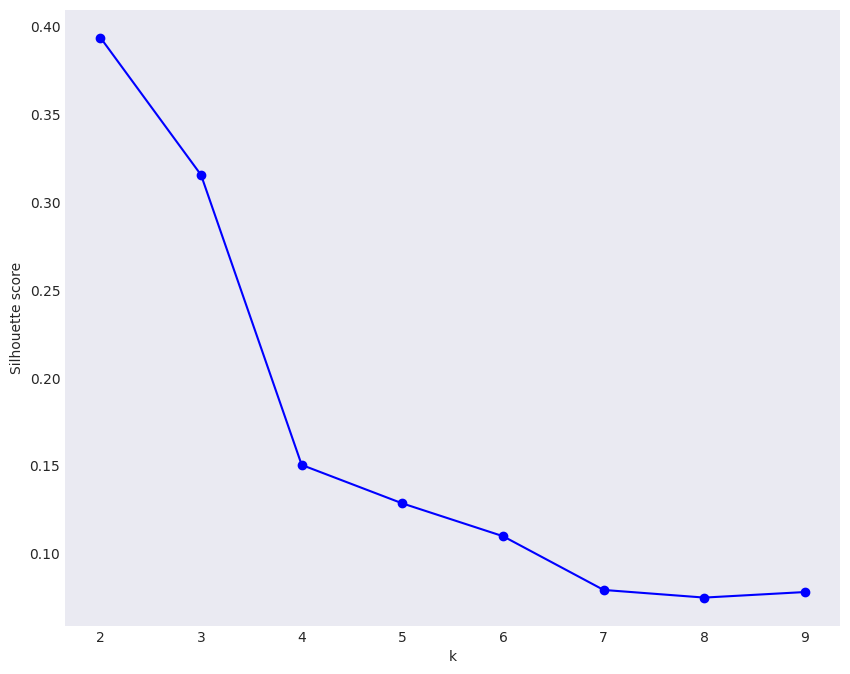

In [187]:
plt.figure(figsize=(10, 8))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel('k', fontsize=10)
plt.ylabel('Silhouette score', fontsize=10)
plt.grid()
plt.show()

According to the silhouette method we can choose four clusters so the results are better then in the elbow method. Bet still, we need six clusters.

**KMeans** can be used for data **preprocessing**, which increases the efficiency of the used classifier. We will check the efficiency of the **Logistic Regression** model without and with the use of the KMeans algorithm.

In [188]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

log_reg = LogisticRegression(multi_class="ovr", max_iter=5000, random_state=2)
log_reg.fit(X_train, y_train)

print("Without KMeans :", log_reg.score(X_test, y_test))

pipeline = Pipeline([
    ("kmeans", KMeans(
        n_clusters=40,
        random_state=2
    )),
    ("log_reg", LogisticRegression(
        multi_class="ovr",
        max_iter=5000,
        random_state=2
    )),
])
pipeline.fit(X_train, y_train)

print("With :", pipeline.score(X_test, y_test))

Without KMeans : 0.9613165931455717
With : 0.9138106549032915


In this case, the use of preprocessing in the form of KMeans resulted in a worse result.

## **DBSCAN**

Another clustering algorithm is DBSCAN.

Wwhile the KMeans algorithm the predict() method to predict the value/class/cluster to which a new data or entire sample belongs, based on what they've learned - **DBSCAN** doesn't allow this.

It can only be applied to complete data that we already have in its entirety. If we add new elements, we have to train the whole model again.

**The principle of operation of this algorithm:**

- for each element of the set, the algorithm counts elements in a small **epsilon** distance. It's called the **epsilon neighborhood**.

- If there are at least **min_samples** of elements in the neighborhood of a given point, within an **epsilon** distance from it, we are dealing with the center of our cluster.

- All elements around this center belong to this cluster.


**IMPORTANT:** All objects that do not belong to any cluster and have no cluster in their vicinity (epsilon distance) are anomalies.

In [189]:
from sklearn.cluster import DBSCAN

# first dbscan classifier with eps = 0.05
dbscan = DBSCAN(eps=0.05, min_samples=6)
dbscan.fit(X)

# second dbscan classifier with eps = 0.2 (bigger epsilon, bigger space around)
dbscan_2 = DBSCAN(eps=0.2, min_samples=6)
dbscan_2.fit(X)

DBSCAN(eps=0.2, min_samples=6)

In [190]:
# graph drawing function
def plot_dbscan(dbscan, X, size):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]

    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

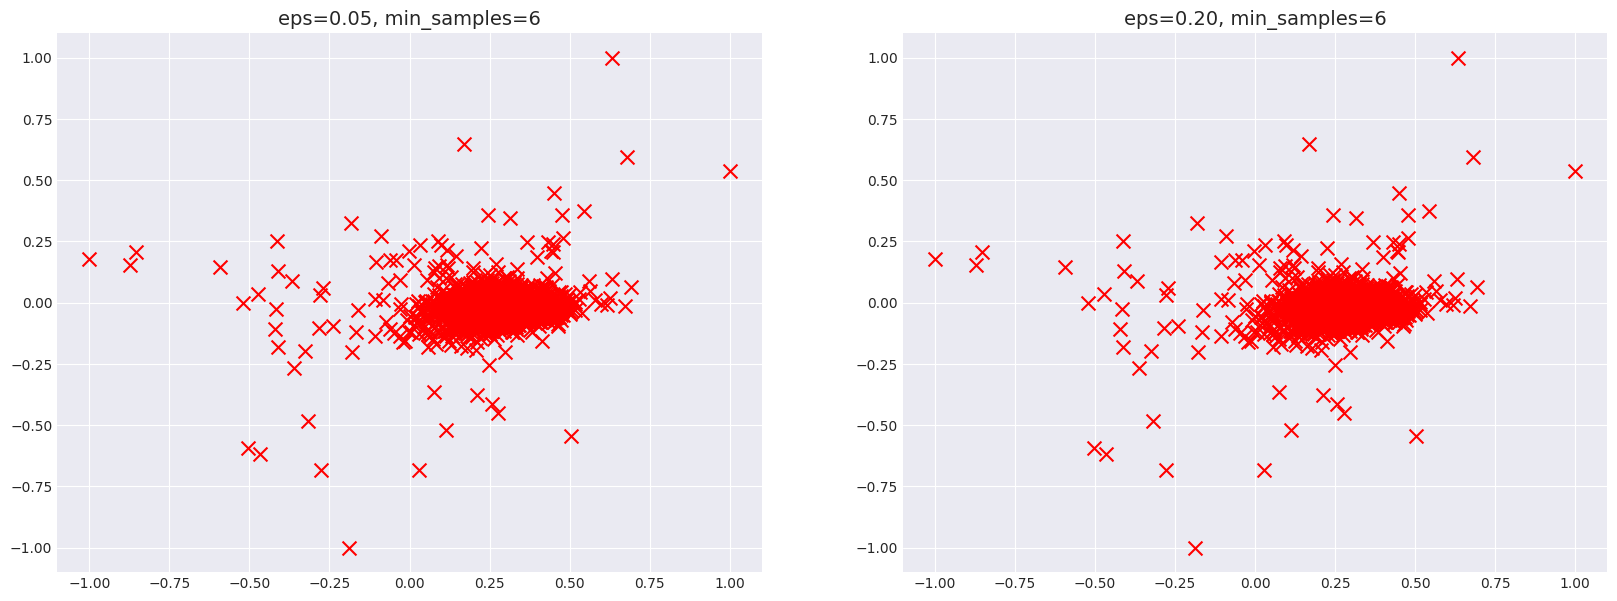

In [191]:
plt.figure(figsize=(20, 7))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan_2, X, size=600)

plt.show()

We can see that in both cases, our algorithm created one large cluster and detected many anomalies (anomalies are X).

## **Gaussian Mixture Models (GMM)**

Algorithm for clustering, based on the probability distribution, and more precisely on the Gaussian distribution.

To plot our cluster boundaries, we use the **plot gaussian mixture** method.

In [192]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

def plot_gaussian_mixture(clf, X, resolution=1000):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clf.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, linewidths=3, colors='b')

    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

    plt.xlabel("$x_1$", fontsize=14)
    plt.tick_params(labelleft=False)

In [193]:
X_train = pd.read_csv('/content/drive/MyDrive/samsung_HAR/samsung_train.txt', header=None, delim_whitespace=True)
X_test  = pd.read_csv('/content/drive/MyDrive/samsung_HAR/samsung_test.txt', header=None, delim_whitespace=True)
X       = pd.concat([X_train , X_test], ignore_index=True)
X = X[[50,95]]
X = X.to_numpy()

y_train = pd.read_csv('/content/drive/MyDrive/samsung_HAR/samsung_train_labels.txt', header=None, delim_whitespace=True)
y_test  = pd.read_csv('/content/drive/MyDrive/samsung_HAR/samsung_test_labels.txt', header=None, delim_whitespace=True)
y       = pd.concat([y_train , y_test], ignore_index=True)
y = y.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)


In [194]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=6, n_init=10, random_state=42, covariance_type="tied")
gm.fit(X)

GaussianMixture(covariance_type='tied', n_components=6, n_init=10,
                random_state=42)

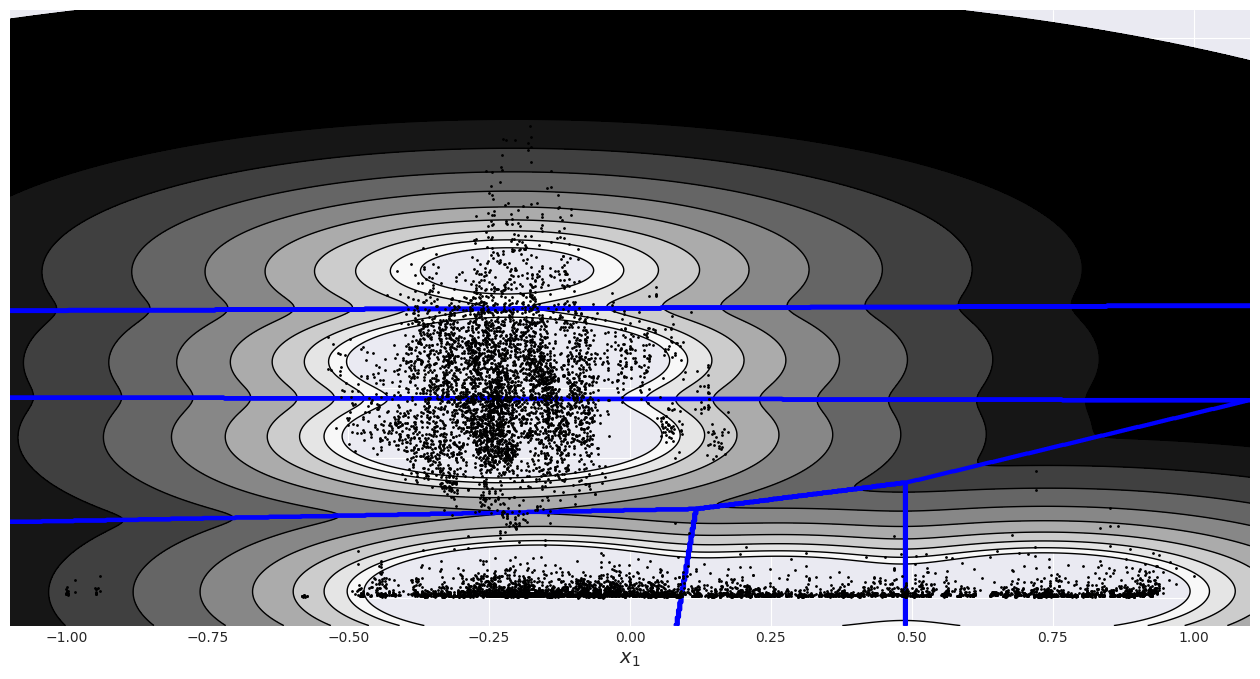

In [195]:
plt.figure(figsize=(16, 8))

plot_gaussian_mixture(gm, X)
plt.show()

### **GMM as an anomaly detector**

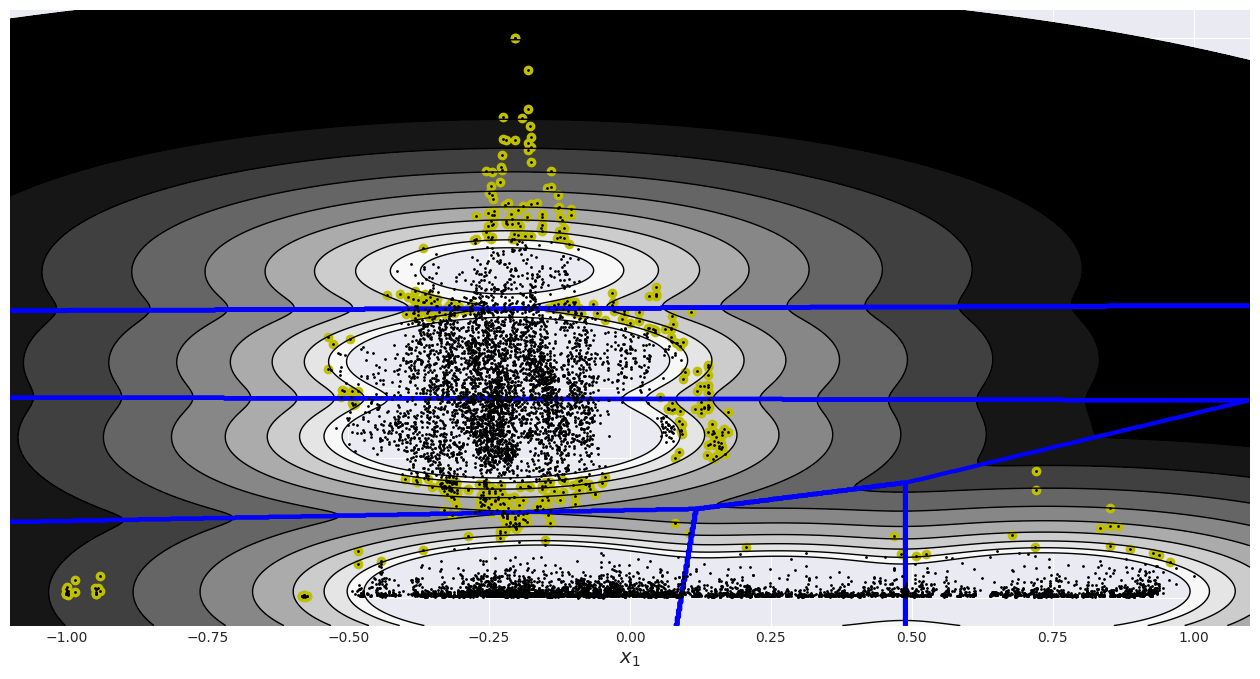

In [196]:
gm = GaussianMixture(n_components=6, n_init=10, random_state=42,covariance_type="tied")
gm.fit(X)

plt.figure(figsize=(16, 8))

plot_gaussian_mixture(gm, X)

# fetch the values for our set which
# tell us how much an item belongs to clusters
density = gm.score_samples(X)

# we create a threshold value
# values that have results from the previous line smaller than ours
# threshold are anomalies, so they are screened out

# in our case, we want to sift out the 5% worst values
threshold = np.percentile(density, 5)

# we filter out these values by simple comparison
anomalie = X[density < threshold]

plt.scatter(anomalie[:, 0], anomalie[:, 1], color='y', marker='o')
plt.show()

The weaker the color, the farther from the center of our cluster, the more anomalies there are.

Unsupervised learning works poorly. The classes we strive for are too little separated from each other. Based on KMeans and Silhouette score, it can be concluded that there should be 3 clusters.

## **What is the difference between:**

- KMeans
- K-fold
- K Nearest Neighbors

**KMeans** - algorithms make inferences from datasets using only input vectors without referring to known, or labelled, outcomes. Other words: groups similar data points together (clusters) and discover underlying patterns. To achieve this objective, K-means looks for a fixed number (**k**) of clusters in a dataset.

**K-fold** - crossvalidation, method used in machine learning to find out how well your machine learning model can predict the outcome of unseen data. We have several so-called folds, which are individual divisions of our data. One fold can be compared to one **train_test_split**.

**K Nearest Neighbors** - (**KNN**), is a type of **supervised learning algorithm** used for both regression and classification. KNN tries to predict the correct class for the test data by calculating the distance between the test data and all the training points. Then select the **K** number of points which is closet to the test data. The KNN algorithm calculates the probability of the test data belonging to the classes of ‘K’ training data and class holds the highest probability will be selected. In the case of regression, the value is the mean of the ‘K’ selected training points.